In [1]:
import torch
import numpy as np
from numpy.random import randint
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import sklearn.datasets
from scipy import sparse
from sklearn.datasets import load_svmlight_file
from random import shuffle
from sklearn.datasets import fetch_mldata
from sklearn import preprocessing

In [2]:
class Queue:
    def __init__(self, max_len):
        self.queue = list()
        self.maxlen = max_len
        self.len = 0
        
    def push(self, grad):
        
        if self.len < self.maxlen:
            self.queue.append(grad)
            self.len += 1
        else:
            ret = self.queue.pop(0)
            self.queue.append(grad)
    
    def sample(self, delay):

        if delay >= self.len:
            delay = 0
            return self.queue[0]
#         print(delay)
        # i-th element in the queue is the i step delayed version of the param
        return self.queue[self.len - delay - 1]


In [3]:
def softmax(x):

    x -= np.max(x, axis=1).reshape(-1,1)
    z = np.exp(x)/ np.sum(np.exp(x), axis=1).reshape(-1,1)

    return z


def ReLu(x):
    
    return np.maximum(x, np.zeros_like(x))


def data_partition(num_workers, X_train, Y_train, separate=True):
    
    size = X_train.shape[0]
    ind = list(range(size))
    shuffle(ind)
    
    if separate:
        worker_size = int(np.floor(size/num_workers))
        data = dict.fromkeys(list(range(num_workers)))

        for w in range(num_workers):
            data[w] = dict()
            if w is not num_workers-1:
                data[w]["X"] = X_train[ind[w*worker_size: (w+1)*worker_size],:]
                data[w]["Y"] = Y_train[ind[w*worker_size: (w+1)*worker_size],:]
            else:
                data[w]["X"] = X_train[ind[w*worker_size:],:]
                data[w]["Y"] = Y_train[ind[w*worker_size:],:]

    else:
        data = dict.fromkeys(list(range(num_workers)))
        for w in range(num_workers):
            data[w] = dict()
            shuffle(ind)
            data[w]["X"] = X_train[ind,:]
            data[w]["Y"] = Y_train[ind,:]

        
    return data


def unpack_data(data):
    
    X_train, Y_train = data["X"], data["Y"]
    
    return X_train, Y_train

In [40]:
class ParamServer:
    def __init__(self, num_workers, max_delay, dim_in, num_classes, 
                 layers, activation, learning_rate=1e-3, num_iter=10000,
                 regularization=1e-2, dataset="a9a", batch_size=100, num_epochs=10):

        self.max_delay = max_delay
        self.queue = Queue(max_delay + 1)
        
        self.num_epochs = num_epochs
        self.num_workers = num_workers
        self.workers = dict.fromkeys(list(range(self.num_workers)))        
        
        self.X_train = None
        self.Y_train = None
        self.X_test = None
        self.Y_test = None
        self.batch_size = batch_size
        self.train_batch_counter = 0
        self.test_batch_counter = 0
        
        self.data_partition = self.get_dataset(dataset) 
    
        for i in range(num_workers):
            self.workers[i] = Worker(i, self, self.data_partition[i], dim_in,
                                     num_classes, layers, activation, regularization)

        self.nn = NeuralNet(dim_in, num_classes, layers, activation, regularization)
        self.lr = learning_rate
        self.num_iter = num_iter
        self.lamda = regularization
        self.num_layers = len(layers)
        self.layers = layers
        self.dim_in = dim_in
        self.num_classes = num_classes
        
        self.clear_grads()
        self.initialize_weights(dim_in, num_classes, layers)
        self.log = dict()
        
           
    def get_dataset(self, dataset="a9a"):
        
        if dataset == "a9a":
            self.num_classes = 2
            X_train, Y_train = load_svmlight_file("data/a9a/a9a.txt")
            X_test, Y_test = load_svmlight_file("data/a9a/a9a.t")
            X_test = sparse.hstack((X_test, np.zeros((X_test.shape[0],1))))
        
            X_train = X_train.tocsc()
            X_test = X_test.tocsc()
            #converting labels from -1,+1 to 0,1
            Y_test += 1
            Y_train += 1
            Y_test /= 2
            Y_train /=2
            
            Y_test = np.eye(self.num_classes)[Y_test.astype("int")]
            Y_train = np.eye(self.num_classes)[Y_train.astype("int")]

        elif dataset == "mnist":
            self.num_classes = 10
            mnist = fetch_mldata('MNIST original', data_home="data/")
            mnist.data = preprocessing.normalize(mnist.data)
            target = np.eye(10)[mnist.target.astype("int")]
            ind = list(range(target.shape[0]))
            shuffle(ind)

            X_train = mnist.data[ind[:int(np.floor(target.shape[0]*0.8))],:]
            Y_train = target[ind[:int(np.floor(target.shape[0]*0.8))],:]
            X_test = mnist.data[ind[int(np.floor(target.shape[0]*0.8)):],:]
            Y_test = target[ind[int(np.floor(target.shape[0]*0.8)):],:]

            
        self.X_test = X_test
        self.Y_test = Y_test
        self.X_train = X_train
        self.Y_train = Y_train

        data = data_partition(self.num_workers, X_train, Y_train, separate=True)
                
        return data
        
        
    def clear_grads(self):
        prev_dim = self.dim_in
        for key, value in enumerate(self.layers):
            self.nn.gradients_W[key] = np.zeros((prev_dim, value))
            self.nn.gradients_b[key] = np.zeros((1, value))
            prev_dim = value
        
        self.nn.gradients_W[self.num_layers] = np.zeros((prev_dim, self.num_classes))
        self.nn.gradients_b[self.num_layers] = np.zeros((1, self.num_classes))


    def initialize_weights(self, dim_in, num_classes, layers):
        prev_dim = dim_in
        for key, value in enumerate(layers):
            self.nn.weights[key] = np.random.randn(prev_dim, value)/np.sqrt(prev_dim)
            self.nn.bias[key] = np.random.randn(1, value)
            prev_dim = value
        
        self.nn.weights[self.num_layers] = np.random.randn(prev_dim, num_classes)/np.sqrt(prev_dim)
        self.nn.bias[self.num_layers] = np.random.randn(1, num_classes)
        self.queue.push([self.nn.weights, self.nn.bias])

    
    def update(self, count):
        gamma_t = self.learning_rate(count)
        weights = dict()
        bias = dict()
        for ind in self.nn.weights.keys():
            weights[ind] = np.zeros_like(self.nn.weights[ind])
            bias[ind] = np.zeros_like(self.nn.bias[ind])

            weights[ind] = self.nn.weights[ind] - gamma_t * self.nn.gradients_W[ind]
            bias[ind] = self.nn.bias[ind] - gamma_t * self.nn.gradients_b[ind]
        
        return weights, bias

            
    def step(self):    
        self.clear_grads()
        size = 0
        loss = 0
        accuracy = 0 
        for ind, worker in self.workers.items():
#             batch_X, batch_Y = worker.get_next_mini_batch()
            batch_X, batch_Y = worker.get_next_mini_batch()
            grads_W, grads_b = worker.compute_mini_batch_gradients(batch_X, batch_Y)
            for layer in range(self.num_layers+1):
                self.nn.gradients_W[layer] += grads_W[layer]/self.num_workers
                self.nn.gradients_b[layer] += grads_b[layer]/self.num_workers
            
            temp_loss = worker.nn.compute_loss(batch_X, batch_Y)* batch_Y.shape[0]
            pred =  worker.nn.predict(batch_X)
            temp_accuracy = np.equal(pred, np.argmax(batch_Y,axis=1)).sum()
    
            loss += temp_loss
            accuracy += temp_accuracy
            size += batch_X.shape[0]
            
        return loss, accuracy, size


    def train(self):
        logs = dict()
        data_size = self.workers[0].data_size
        num_counts = int(np.floor(data_size/self.batch_size))+ 1
        for epoch in range(self.num_epochs):
            logs[epoch] = dict()
            logs[epoch]["train_loss"] = []
            logs[epoch]["train_acc"] = []
            logs[epoch]["test_loss"] = []
            logs[epoch]["test_acc"] = []
            running_loss = 0
            running_acc = 0
            running_size = 0
            for _, worker in self.workers.items():
                worker.shuffle_data()
                worker.reset_batch_counter()

            for count in range(1, num_counts):
                step_loss, step_accuracy, size = self.step()
                weights, bias = self.update(count)
                
                self.queue.push([weights, bias])
                self.nn.weights, self.nn.bias = weights, bias
                running_loss += step_loss
                running_acc += step_accuracy
                running_size += size
                #print([self.queue.queue[i][1] for i in range(self.queue.len)],"\n")
#                 if count%10 == 0:
#                     break
#                 if count%100 == 0:
#                     loss, accuracy = self.compute_test()

#                 print("count", count,"train_loss", round(train_loss,2),
#                       "test_loss",round(loss,2), "test_accuracy", round(accuracy,2))
            
            epoch_train_loss = running_loss / running_size
            epoch_train_accuracy = running_acc/ running_size

            epoch_loss, epoch_accuracy = self.compute_test()
#             epoch_train_loss, epoch_train_accuracy = self.compute_train()
#             logs[epoch]["train_loss"].append(epoch_train_loss)
#             logs[epoch]["test_loss"].append(epoch_loss)
#             logs[epoch]["train_acc"].append(epoch_train_accuracy)
#             logs[epoch]["test_acc"].append(epoch_accuracy)
            logs[epoch]["train_loss"] = epoch_train_loss
            logs[epoch]["test_loss"] = epoch_loss
            logs[epoch]["train_acc"] = epoch_train_accuracy
            logs[epoch]["test_acc"] = epoch_accuracy


            print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
            print("epoch", epoch,"train_loss", round(epoch_train_loss,2),
                  "test_loss",round(epoch_loss,2), "test_accuracy", round(epoch_accuracy,2))
            
        return logs
            
    def learning_rate(self, count):

#         return self.lr
        return self.lr/count

    def compute_train(self):
        counter = None
        loss = 0
        accuracy = 0
        while counter is not 0:
            batch_X, batch_Y, counter = self.get_train_mini_batch()
            loss += self.nn.compute_loss(batch_X, batch_Y)* batch_Y.shape[0]
            pred = self.nn.predict(batch_X)
            accuracy += np.equal(pred,np.argmax(batch_Y, axis=1)).sum()
        
        loss /= self.Y_train.shape[0]
        accuracy /= self.Y_train.shape[0]

        return loss, accuracy

    def compute_test(self):
        counter = None
        loss = 0
        accuracy = 0
        while counter is not 0:
            batch_X, batch_Y, counter = self.get_test_mini_batch()
            loss += self.nn.compute_loss(batch_X, batch_Y)* batch_Y.shape[0]
            pred = self.nn.predict(batch_X)
            accuracy += np.equal(pred,np.argmax(batch_Y, axis=1)).sum()
        
        loss /= self.Y_test.shape[0]
        accuracy /= self.Y_test.shape[0]

        return loss, accuracy
        
        
    def get_test_mini_batch(self):

        if (self.test_batch_counter + 1)* self.batch_size < self.X_test.shape[0]:
#             batch_X = self.X_test.tocsc()[self.test_batch_counter* self.batch_size: (self.test_batch_counter+1)*self.batch_size,:]
            batch_X = self.X_test[self.test_batch_counter* self.batch_size: (self.test_batch_counter+1)*self.batch_size,:]
            batch_Y = self.Y_test[self.test_batch_counter* self.batch_size: (self.test_batch_counter+1)*self.batch_size,:]
            self.test_batch_counter += 1

        else:
#             batch_X = self.X_test.tocsc()[self.test_batch_counter* self.batch_size:,: ]
            batch_X = self.X_test[self.test_batch_counter* self.batch_size:,: ]
            batch_Y = self.Y_test[self.test_batch_counter* self.batch_size:,: ]
            self.test_batch_counter = 0

        return batch_X, batch_Y, self.test_batch_counter

    def get_train_mini_batch(self):

        if (self.train_batch_counter + 1)* self.batch_size < self.X_train.shape[0]:
#             batch_X = self.X_train.tocsc()[self.train_batch_counter* self.batch_size: (self.train_batch_counter+1)*self.batch_size,:]
            batch_X = self.X_train[self.train_batch_counter* self.batch_size: (self.train_batch_counter+1)*self.batch_size,:]
            batch_Y = self.Y_train[self.train_batch_counter* self.batch_size: (self.train_batch_counter+1)*self.batch_size,:]
            self.train_batch_counter += 1

        else:
#             batch_X = self.X_train.tocsc()[self.train_batch_counter* self.batch_size:,: ]
            batch_X = self.X_train[self.train_batch_counter* self.batch_size:,: ]
            batch_Y = self.Y_train[self.train_batch_counter* self.batch_size:,: ]
            self.train_batch_counter = 0

        return batch_X, batch_Y, self.train_batch_counter



In [5]:
class Worker:
    def __init__(self, ind, parent, data_partition, dim_in, num_classes,
                 layers, activation, regularization,batch_size=100):

        self.ind = ind
        self.parent = parent
        self.nn = NeuralNet(dim_in, num_classes, layers, activation, regularization)
        self.X_train, self.Y_train = unpack_data(data_partition)
        self.data_size = self.X_train.shape[0]
        self.batch_size = batch_size
        self.batch_counter = 0
        
    def shuffle_data(self):
        ind = list(range(self.data_size))
        shuffle(ind)
        self.X_train = self.X_train[ind,:]
        self.Y_train = self.Y_train[ind,:]

    def reset_batch_counter(self):
        self.batch_counter = 0
    
    def get_delayed_params(self):
        
        if self.parent.max_delay is not 0:
            delay = np.random.randint(0, self.parent.max_delay)
            delayed_params = self.parent.queue.sample(delay)
        else:
            delay = 0
            delayed_params = self.parent.queue.sample(0)
        
        truth = delayed_params[1][0]==self.parent.nn.bias[0]
#         print(truth)
#         if sum(truth[0])==10:
#             print("delay=",delay, self.parent.queue.len)
        
        return delayed_params
        
    def compute_mini_batch_gradients(self, X, Y):
        
        params = self.get_delayed_params()
#         assert(params == [self.parent.nn.weights, self.parent.nn.bias])
        grads = self.nn.grad(X, Y, params)

        return grads
    
    def get_next_mini_batch(self):
        
        if (self.batch_counter + 1)* self.batch_size < self.X_train.shape[0]:
            batch_X = self.X_train[self.batch_counter* self.batch_size: (self.batch_counter+1)*self.batch_size, :]
            batch_Y = self.Y_train[self.batch_counter* self.batch_size: (self.batch_counter+1)*self.batch_size, :]
            self.batch_counter += 1

        else:
            batch_X = self.X_train[self.batch_counter* self.batch_size:,: ]
            batch_Y = self.Y_train[self.batch_counter* self.batch_size:,: ]
            self.batch_counter = 0
            # end of epoch
            # do shuffling at the end of each epoch?
            
            
        return batch_X, batch_Y
        
        
        

In [6]:
class NeuralNet():
    def __init__(self, dim_in, num_classes, layers, activation='softmax', regularization=1e-3):
        self.dim_in = dim_in
        self.num_classes = num_classes
        self.num_layers = len(layers)
        self.layers = layers
        self.weights = dict.fromkeys(range(self.num_layers + 1))
        self.bias = dict.fromkeys(range(self.num_layers + 1))
        self.gradients_W = dict.fromkeys(range(self.num_layers + 1))
        self.gradients_b = dict.fromkeys(range(self.num_layers + 1))
        self.regularization = regularization
        
        if activation == 'softmax':
            self.activation = softmax
        else:
            self.activation = ReLu
        
        prev_dim = dim_in
        for key, value in enumerate(layers):
            self.weights[key] = np.random.randn(prev_dim, value)
            self.bias[key] = np.random.randn(1, value)
            prev_dim = value
        
        self.weights[self.num_layers] = np.random.randn(prev_dim, num_classes)
        self.bias[self.num_layers] = np.random.randn(1, num_classes)
        self.cache = []
        

    def calculate_forward_layer(self, W, b, X):
        
#         Z = np.dot(X, W) + b
#         print(X.shape, W.shape, b.shape)
        Z = X.dot(W) + b
        Z = self.activation(Z)

        return Z

    
    def assign_weights(self, delayed_params):
        
        weights, bias = delayed_params
        self.weights = weights
        self.bias = bias

    
    def forward(self,X):
        self.cache = []
        temp = X
        for layer in range(self.num_layers):
            temp = self.calculate_forward_layer(self.weights[layer], self.bias[layer], temp)
            self.cache.append(temp)
            if layer == self.num_layers - 1:
                break
        
#         print(self.weights[self.num_layers].shape, self.bias[self.num_layers].shape, temp.shape)
#         out = np.dot(temp, self.weights[self.num_layers]) + self.bias[self.num_layers]
        out = temp.dot(self.weights[self.num_layers]) + self.bias[self.num_layers]
        out = softmax(out)
        self.cache.append(out)

        return out
    

    def cross_entropy_loss(self, Y, Z):

        loss = -np.sum(Y*np.log(Z))
        
        return loss/Y.shape[0]
        

    def grad(self, X, Y, delayed_params):
        
        
        self.assign_weights(delayed_params)
        self.forward(X)
        
        # for squared loss, as well as cross entropy loss
        delta = self.cache[-1] - Y
        
        for layer in reversed(range(self.num_layers+1)):
        
            if layer is not 0:
            
                temp_grad_W = (self.cache[layer-1].T).dot(delta)
                temp_grad_b = np.sum(delta, axis=0, keepdims=True)

                self.gradients_W[layer] = temp_grad_W + self.regularization * self.weights[layer]
                self.gradients_b[layer] = temp_grad_b

                delta = delta.dot(self.weights[layer].T) * (1- np.power(self.cache[layer-1], 2))

            else:
                temp_grad_W = (X.T).dot(delta)
                temp_grad_b = np.sum(delta, axis=0, keepdims=True)

                self.gradients_W[layer] = temp_grad_W + self.regularization * self.weights[layer]
                self.gradients_b[layer] = temp_grad_b            
            
        return self.gradients_W, self.gradients_b
            
        
    def compute_loss(self, batch_X, batch_Y):
        Z = self.forward(batch_X)
        loss = self.cross_entropy_loss(batch_Y,Z)
        
        return loss

    def predict(self, X):
        
        Z = self.forward(X)
        return np.argmax(Z, axis=1)
        
    def accuracy(self, pred, Y):
        
        print(np.equal(pred,Y).sum()/pred.shape[0])


In [71]:
server = ParamServer(num_workers=10, max_delay=100, dim_in=784, num_classes=10,
                     layers=[], activation="softmax",learning_rate=1e-2, num_iter=10000,
                     regularization=0, dataset="mnist", num_epochs=50, batch_size=100)

In [22]:
server.X_train.shape, server.X_test.shape

((56000, 784), (14000, 784))

In [23]:
for _,w in server.workers.items():
    print(w.X_train.shape, w.Y_train.shape)

(14000, 784) (14000, 10)
(14000, 784) (14000, 10)
(14000, 784) (14000, 10)
(14000, 784) (14000, 10)


In [72]:
from time import time as time
t1=time()
logs = server.train()
t2=time()
print(t2-t1)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
epoch 0 train_loss 2.55 test_loss 2.35 test_accuracy 0.32
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
epoch 1 train_loss 2.39 test_loss 2.22 test_accuracy 0.31
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
epoch 2 train_loss 2.24 test_loss 2.14 test_accuracy 0.45
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
epoch 3 train_loss 2.15 test_loss 2.09 test_accuracy 0.51
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
epoch 4 train_loss 2.09 test_loss 2.03 test_accuracy 0.63
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
epoch 5 train_loss 2.04 test_loss 1.99 test_accuracy 0.66
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
epoch 6 train_loss 1.99 test_loss 1.94 test_accuracy 0.69
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
epoch 7 train_loss 1.94 test_loss 1.9 test_accuracy 0.68
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
epoch 8 train_loss 1.9 test_loss 1.85 test_accuracy 0.7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
epoch 9 train_loss 1.86 test_loss 1.81 test_accuracy 0.72
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
epoch 10 train_loss 1.82 test_loss 1.7

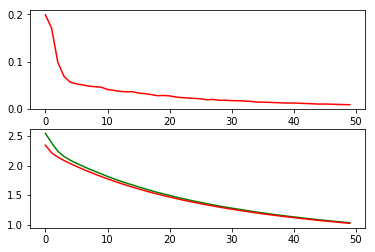

In [73]:
from matplotlib import pyplot as plt

gen_error = [abs(logs[i]["train_loss"] - logs[i]["test_loss"]) for i in range(server.num_epochs)]
train_error = [logs[i]["train_loss"] for i in range(server.num_epochs)]
test_error = [logs[i]["test_loss"] for i in range(server.num_epochs)]

fig, ax = plt.subplots(2)
ax[0].plot(gen_error, 'r')
# ax.plot(gen_error, 'r')
ax[1].plot(train_error, 'g')
ax[1].plot(test_error, 'r')

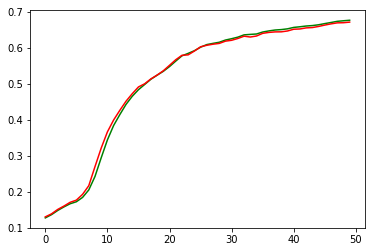

In [52]:
train_accuracy = [logs[i]["train_acc"] for i in range(server.num_epochs)]
test_accuracy = [logs[i]["test_acc"] for i in range(server.num_epochs)]

fig, ax = plt.subplots()

ax.plot(train_accuracy,'g')
ax.plot(test_accuracy,'r')

In [ ]:
from sklearn import linear_model

clf = linear_model.LogisticRegression()

# X_train, Y_train = load_svmlight_file("data/a9a/a9a.txt")
# X_test, Y_test = load_svmlight_file("data/a9a/a9a.t")
# X_test = sparse.hstack((X_test, np.zeros((X_test.shape[0],1))))

mnist = fetch_mldata('MNIST original', data_home="data/")
target = np.eye(10)[mnist.target.astype("int")]
mnist.data = preprocessing.normalize(mnist.data)


In [ ]:
ind = list(range(mnist.data.shape[0]))
shuffle(ind)
X_train = mnist.data[ind[:int(np.floor(target.shape[0]*0.8))],:]
Y_train = target[ind[:int(np.floor(target.shape[0]*0.8))],:]
X_test = mnist.data[ind[int(np.floor(target.shape[0]*0.8)):],:]
Y_test = target[ind[int(np.floor(target.shape[0]*0.8)):],:]


In [ ]:
X_train.shape , X_test.shape, Y_train.shape, Y_test.shape

In [ ]:
clf.fit(X_train, Y_train.argmax(axis=1))

In [ ]:
clf.score(server.X_test, server.Y_test.argmax(axis=1)), server.compute_test(), server.compute_train()


In [ ]:
Z=clf.predict_log_proba(X_test)
Y_test += 1
Y_test /= 2
Y_test = np.eye(2)[Y_test.astype("int")]

loss = -np.sum(Y_test*Z)
loss/= Y_test.shape[0]
print(loss)

In [ ]:
Z = clf.predict_log_proba(X_test)
loss = -np.sum(Y_test*Z)
loss/= Y_test.shape[0]
print(loss)

In [ ]:
server.compute_test(), server.compute_train()

In [ ]:
(server.nn.weights[0].nbytes + server.nn.weights[1].nbytes + server.nn.weights[2].nbytes)/1024

In [ ]:
(server.nn.weights[0].nbytes , server.nn.weights[1].nbytes , server.nn.weights[2].nbytes)